In [1]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

In [2]:
df = pd.read_csv("true-false.csv")

In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

encoded_data = tokenizer.batch_encode_plus(
    df.question.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt',
    truncation = True,
    padding = 'max_length'
)


In [4]:
answer = df.answer.values
answer[answer == 'yes'] = 1
answer[answer == 'no'] = 0
labels = torch.tensor(answer.astype('int64'))


In [5]:
input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']

dataset = torch.utils.data.TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])


In [6]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)

batch_size = 32
epochs = 5
learning_rate = 2e-5
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [7]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True
)


In [8]:
# Step 8: Define the device and move model and data to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(1, epochs+1):
    model.train()

    total_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids = batch[0].to(device)
        attention_masks = batch[1].to(device)
        labels = batch[2].to(device)
        outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print("Training loss: {0:.2f}".format(avg_train_loss))

    model.eval()
    val_accuracy = 0
    for batch in val_dataloader:
        input_ids = batch[0].to(device)
        attention_masks = batch[1].to(device)
        labels = batch[2].to(device)
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_masks)
        logits = outputs[0]
        preds = torch.argmax(logits, dim=1).flatten()
        accuracy = torch.sum(preds == labels).item()
        val_accuracy += accuracy
    avg_val_accuracy = val_accuracy / len(val_dataset)
    print("Validation Accuracy: {0:.2f}".format(avg_val_accuracy))


KeyboardInterrupt: 

In [ ]:
import json

test_questions = json.load(open('../competition/autocast_competition_test_set.json'))
test_ids = [q['id'] for q in test_questions]
test_questions_df = pd.DataFrame(test_questions)

In [ ]:
# test_question = "Is the sun red?"

for index, row in test_questions_df.iterrows():
    encoded_test = tokenizer.encode_plus(
        row['question'], #test_question,
        add_special_tokens=True,
        return_attention_mask=True,
        padding='max_length',
        max_length=256,
        return_tensors='pt',
        truncation = True
        )

    input_ids = encoded_test['input_ids'].to(device)
    attention_mask = encoded_test['attention_mask'].to(device)

    with torch.no_grad():
        output = model(input_ids, attention_mask=attention_mask)

    logits = output[0]
    prob = torch.softmax(logits, dim=1)

    print("Probability of 'Yes': {0:.2f}".format(prob[0][1].item()))
    print("Probability of 'No': {0:.2f}".format(prob[0][0].item()))
    print()


Probability of 'Yes': 0.61
Probability of 'No': 0.39

Probability of 'Yes': 0.33
Probability of 'No': 0.67

Probability of 'Yes': 0.03
Probability of 'No': 0.97

Probability of 'Yes': 0.02
Probability of 'No': 0.98

Probability of 'Yes': 0.05
Probability of 'No': 0.95

Probability of 'Yes': 0.05
Probability of 'No': 0.95

Probability of 'Yes': 0.05
Probability of 'No': 0.95

Probability of 'Yes': 0.65
Probability of 'No': 0.35

Probability of 'Yes': 0.25
Probability of 'No': 0.75

Probability of 'Yes': 0.03
Probability of 'No': 0.97

Probability of 'Yes': 0.02
Probability of 'No': 0.98

Probability of 'Yes': 0.06
Probability of 'No': 0.94

Probability of 'Yes': 0.03
Probability of 'No': 0.97

Probability of 'Yes': 0.12
Probability of 'No': 0.88

Probability of 'Yes': 0.08
Probability of 'No': 0.92

Probability of 'Yes': 0.03
Probability of 'No': 0.97

Probability of 'Yes': 0.03
Probability of 'No': 0.97

Probability of 'Yes': 0.02
Probability of 'No': 0.98

Probability of 'Yes': 0.03
P

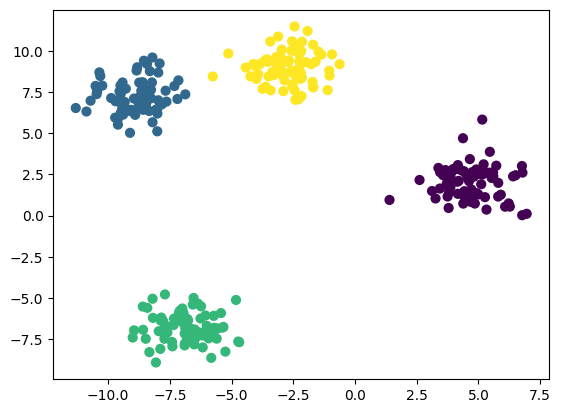

In [4]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

def gmm_assign_clusters(X, pi, mu, sigma):
    """
    X: numpy array of shape (n, d), where n is the number of data points and d is the dimensionality
    pi: numpy array of shape (k,), the mixing coefficients
    mu: numpy array of shape (k, d), the means of the Gaussian distributions
    sigma: numpy array of shape (k, d, d), the covariance matrices of the Gaussian distributions
    Returns: numpy array of shape (n,), the cluster assignments for each data point
    """

    n, d = X.shape
    k = len(pi)
    log_probs = np.zeros((n, k))

    # compute log probability of each point under each Gaussian distribution
    for i in range(k):
        log_probs[:, i] = np.log(pi[i]) + multivariate_normal.logpdf(X, mean=mu[i], cov=sigma[i])

    # assign each point to the cluster with the highest probability
    return np.argmax(log_probs, axis=1)

# Generate sample data
X, y_true = make_blobs(n_samples=300, centers=4, random_state=42)

# Train GMM on sample data
gmm = GaussianMixture(n_components=4, random_state=42)
gmm.fit(X)

# Get GMM parameters
pi = gmm.weights_
mu = gmm.means_
sigma = gmm.covariances_

# Assign clusters using our function
clusters = gmm_assign_clusters(X, pi, mu, sigma)

# Visualize clusters
plt.scatter(X[:, 0], X[:, 1], c=clusters, s=40, cmap='viridis')
plt.show()
